In [1]:
import numpy as np
import scipy as sp
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import random as rand
import math
from numpy import linalg as LA
from numpy.linalg import inv
import networkx as nx
import heapq
import csv
import os

In [2]:
def eigcent(J): #hub detection by eigenvector centrality
    w, v = LA.eig(J)
    return v[:,0]

def degcent(K): #hub detection by degree centrality
    deghub=np.zeros(len(K))
    for i in range(0,len(K)):
        deghub[i]=sum(K[i])/len(K)
    return deghub

def betcent(J): #here im assuming that in a weighted network with a continuum of weights, there is only 1
                             #geodesic between 2 nodes
    G=nx.Graph()
    Nregions=len(J)
    for i in range(0,Nregions):
        for j in range(0,i):
            if J[i][j]>0.000000000000000000001:
                G.add_edge(i, j, weight=1/J[i][j])
    bethub=np.zeros(Nregions)  
    for i in range(0,Nregions):
        for j in range(0,Nregions):
            for k in range(0,j):
                if i!=j and i!=k:
                    sp=nx.dijkstra_path(G,j,k)
                    if i in sp:
                        bethub[i]=bethub[i]+1
    bethub=[2*k /((Nregions-1)*(Nregions-2)) for k in bethub]
    return bethub

def betweenness(J): #betweenness centrality
    N=len(J)
    G=nx.Graph()
    for i in range(0,N):
        for j in range(0,i):
            G.add_edge(i, j, weight=1/J[i][j])
    return nx.betweenness_centrality(G,weight='weight',normalized=True)

def globalefficiency(J,N): #global efficiency
    G=nx.Graph()
    for i in range(0,N):
        for j in range(0,i):
            if J[i][j]>0.000000000000000000001:
                G.add_edge(i, j, weight=1/J[i][j])  
    Linv=0
    for i in range(0,N):
        for j in range(0,i):         
            Linv=Linv+1/nx.dijkstra_path_length(G,i,j)
    Linv=Linv/(N*(N-1))
    return Linv

def GRC(J,N): #global reaching centrality
    G=nx.Graph()
    for i in range(0,N):
        for j in range(0,i):
            G.add_edge(i, j, weight=J[i][j])
    return nx.global_reaching_centrality(G,weight='weight',normalized=False)

def charpat(J,N): #characteristic path length
    G=nx.Graph()
    for i in range(0,N):
        for j in range(0,i):
            if J[i][j]>0.000000000000000000001:
                G.add_edge(i, j, weight=1/J[i][j])  
    L=0
    for i in range(0,N):
        for j in range(0,i):         
            L=L+nx.dijkstra_path_length(G,i,j)
    L=L*2/(N*(N-1))
    return L 

def modularity(connectivity,partitioning):
    J=connectivity
    Ψ=partitioning
    N=len(J)
    k=np.zeros(N)
    for i in range(0,N):
        k[i]=sum(J[i])
    m=0.5*sum(k)
    Q=0
    for i in range(0,N):
        for j in range(0,N):
            if Ψ[i]==Ψ[j]:
                Q=Q+J[i][j]-k[i]*k[j]/(2*m)
    Q=Q/(2*m)
    return Q

def communities(J,Ψ): #converting from a partitioning list to a list of communities
    N=len(Ψ)
    comlab=[] #list of community labels in order of appearance in Ψ
    C=[]
    for i in range(0,N):
        if Ψ[i] not in comlab:
            comlab.append(Ψ[i])
            C.append([i])
        else:
            C[comlab.index(Ψ[i])].append(i)
    return C,comlab

def sigtot(J,c): #sum of weights of links incident to nodes in community c
    n=len(c)
    Σtot=0
    for i in range(0,n):
        Σtot=Σtot+sum(J[c[i]])
    return Σtot

def kayin(J,c,i): #sum of weights of links from node i to the nodes in community c
    n=len(c)
    kin=0
    for j in range(0,n):
        kin=kin+J[i][c[j]]
    return kin  

def partitioning(J,C,comlab): #converting from a list of communities to a partitioning list
    N=len(J)
    nm=len(comlab)
    Ψ=np.zeros(N)
    for i in range(0,nm):
        for j in range(0,len(C[i])):
            Ψ[C[i][j]]=comlab[i]
    return Ψ

def transference(J,Ψ,C,comlab,nm,m,i,j): #gain of modularity associated with transfering i from its own community to j's
    N=len(J)
    ci=C[comlab.index(Ψ[i])].copy()
    ci.pop(ci.index(i))
    cj=C[comlab.index(Ψ[j])].copy()
    if Ψ[i]==Ψ[j]:
        cj.pop(cj.index(i))
    Δsub=sigtot(J,ci)*sum(J[i])/(2*m**2) - kayin(J,ci,i)/(2*m)
    Δadd=kayin(J,cj,i)/(2*m) - sigtot(J,cj)*sum(J[i])/(2*m**2)
    return Δsub + Δadd

def modularize(J,Ψ):
    N=len(J)
    Q=modularity(J,Ψ)
    comms=communities(J,Ψ)
    C=comms[0]
    comlab=comms[1]
    nm=len(comlab)
    m=0.5*sum(sum(J))
    for i in range(0,N):
        ΔQ=np.zeros(N)
        for j in range(0,N):
            Δ=transference(J,Ψ,C,comlab,nm,m,i,j)
            if Δ>0:
                ΔQ[j]=Δ
        jstar=np.argmax(ΔQ)
        if ΔQ[jstar]>0:
            ci=C[comlab.index(Ψ[i])]
            cjstar=C[comlab.index(Ψ[jstar])]
            ci.pop(ci.index(i)) #remove i from its community
            cjstar.append(i) #add i to j's commmunity
            Ψ=partitioning(J,C,comlab)
    return C,comlab,Ψ

def consolidate(J,Ψnew,Cnew,comlabnew):
    Nnew=len(comlabnew)
    Jnew=np.zeros((Nnew,Nnew))
    C=Cnew
    for i in range(0,Nnew):
        ci=C[i]
        for j in range (0,Nnew):
            cj=C[j]
            #n=len(c)
            for k in ci:
                for l in cj:
                    Jnew[i][j]=Jnew[i][j]+J[k][l]
    return Jnew

def UltimateModularity(J,tolerance):
    Clog=[]
    Jlog=[]
    part=np.linspace(0,len(J)-1,len(J))
    modold=modularity(J,part)
    cc=modularize(J,part)
    Ψnew=cc[2]
    modnew=modularity(J,Ψnew)
    while abs(modnew-modold)>tolerance:
        modold=modnew
        cc=modularize(J,Ψnew)
        Ψnew=cc[2]
        modnew=modularity(J,Ψnew)
    comnew=communities(J,Ψnew)
    Cnew=comnew[0]
    Clog.append(Cnew)
    comlabnew=comnew[1]
    Jnew=consolidate(J,Ψnew,Cnew,comlabnew)
    Jlog.append(Jnew)
    part=np.linspace(0,len(Jnew)-1,len(Jnew))

    while part.tolist()!=Ψnew.tolist():
        modold=modularity(Jnew,part)
        cc=modularize(Jnew,part)
        Ψnew=cc[2]
        modnew=modularity(Jnew,Ψnew)

        while abs(modnew-modold)>tolerance:
            modold=modnew
            cc=modularize(Jnew,Ψnew)
            Ψnew=cc[2]
            modnew=modularity(Jnew,Ψnew)
        comnew=communities(Jnew,Ψnew)
        Cnew=comnew[0]
        Clog.append(Cnew)
        comlabnew=comnew[1]
        Jnew=consolidate(Jnew,Ψnew,Cnew,comlabnew)
        Jlog.append(Jnew)
        part=np.linspace(0,len(Jnew)-1,len(Jnew))
        cc=modularize(Jnew,part)
        Ψnew=cc[2]
    return modularity(Jnew,Ψnew),Ψnew,Jnew,Clog,Jlog

In [4]:
J104=[] #connecivity matrix averaged 100 subjects, 3 runs each

with open('isi/100_SUBJECTS_AVERAGE_104.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        for j in range(0,len(row)):
            J104.append(float(row[j]))

J104unnorm=J104.copy()
J104=[k / max(J104) for k in J104]
N104=len(row)
J104=np.reshape(J104,(N104,N104))
J104unnorm=np.reshape(J104unnorm,(N104,N104))
ind104=np.linspace(0,N104-1,N104)

J104labels=[] 
import csv
with open('isi/104 with labels.csv', newline='') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        J104labels.append(row[0])
J104labels=J104labels[1:]

J84labels=[] 
import csv
with open('isi/volumes_84_with_labels.csv', newline='') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        J84labels.append(row[0])

J84=[] #connecivity matrix averaged 100 subjects, 3 runs
import csv
with open('isi/AVERAGE_CONNECTIVITY_84_MAY2.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        for j in range(0,len(row)):
            J84.append(float(row[j]))

J84unnorm=J84.copy()
J84=[k / max(J84) for k in J84]
N84=len(row)
J84=np.reshape(J84,(N84,N84))
J84unnorm=np.reshape(J84unnorm,(N84,N84))
ind84=np.linspace(0,N84-1,N84)

vol=[]
import csv
with open('isi/volumes.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        vol.append(float(row[1]))

J104vunnorm=np.zeros((N104,N104))
J104v=np.zeros((N104,N104))  #Network normalized by sum volumes
for i in range(0,N104):
    for j in range(0,N104):
        J104vunnorm[i][j]=J104unnorm[i][j]/(vol[i]+vol[j])
        
J104vmax=J104vunnorm.max()
for i in range(0,N104):
    for j in range(0,N104):
        J104v[i][j]=J104vunnorm[i][j]/J104vmax

vol84=[]
import csv
with open('isi/volumes_84_with_labels.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        vol84.append(float(row[1]))

J84vunnorm=np.zeros((84,84))#Network normalized by sum volumes 
J84v=np.zeros((84,84)) 
for i in range(0,84):
    for j in range(0,84):
        J84vunnorm[i][j]=J84unnorm[i][j]/(vol84[i]+vol84[j])
        
J84vmax=J84vunnorm.max()
for i in range(0,84):
    for j in range(0,84):
        J84v[i][j]=J84vunnorm[i][j]/J84vmax

In [5]:
Jall=[] #all extended matrices 
Junnormall=[]
Jvall=[] #all volume-normalized extended matrices 
volall=[]

directory='isi/Individuals/100 subjects/extended_matrices'
files = os.listdir(directory) 
for file in files:
    J=[]
    with open(os.path.join(directory, file), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            for j in range(0,len(row)):
                J.append(float(row[j]))
    Junnorm=J.copy()
    J=[k / max(J) for k in J]
    Nregions=len(row)
    J=np.reshape(J,(Nregions,Nregions))
    Junnorm=np.reshape(Junnorm,(Nregions,Nregions))
    Jall.append(J)
    Junnormall.append(Junnorm)

directory='isi/Individuals/100 subjects/volumes'
files = os.listdir(directory)
for file in files:
    vol=[]
    with open(os.path.join(directory, file), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            vol.append(float(row[1]))
    volall.append(vol)

for k in range(0,len(files)):
    Jv=np.zeros((Nregions,Nregions))
    Junnorm=Junnormall[k]
    J=Jall[k]
    vol=volall[k]
    for i in range(0,Nregions):
        for j in range(0,Nregions):
            Jv[i][j]=Junnorm[i][j]/(vol[i]+vol[j])
    Jmaxv=Jv.max()
    for i in range(0,Nregions):
        for j in range(0,Nregions):
            Jv[i][j]=Jv[i][j]/Jmaxv
    Jvall.append(Jv)

In [6]:
Jrall=[] #all restricted matrices
Jrunnormall=[]
Jvrall=[] #all volume-normalized restricted matrices
volrall=[]

directory='isi/Individuals/100 subjects/restricted_matrices'
files = os.listdir(directory) 
for file in files: 
    Jr=[]
    with open(os.path.join(directory, file), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            for j in range(0,len(row)):
                Jr.append(float(row[j]))
    Jrunnorm=Jr.copy()
    Jr=[k / max(Jr) for k in Jr]
    Nregionsr=len(row)
    Jr=np.reshape(Jr,(Nregionsr,Nregionsr))
    Jrunnorm=np.reshape(Jrunnorm,(Nregionsr,Nregionsr))
    Jrall.append(Jr)
    Jrunnormall.append(Jrunnorm)

directory='isi/Individuals/100 subjects/restricted_volumes'
files = os.listdir(directory)
for file in files:
    volr=[]
    with open(os.path.join(directory, file), newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in reader:
            volr.append(float(row[1]))
    volrall.append(volr)

for k in range(0,len(files)):
    Jvr=np.zeros((Nregionsr,Nregionsr))
    Jrunnorm=Jrunnormall[k]
    Jr=Jrall[k]
    volr=volrall[k]
    for i in range(0,Nregionsr):
        for j in range(0,Nregionsr):
            Jvr[i][j]=Jrunnorm[i][j]/(volr[i]+volr[j])
    Jmaxvr=Jvr.max()
    for i in range(0,Nregionsr):
        for j in range(0,Nregionsr):
            Jvr[i][j]=Jvr[i][j]/Jmaxvr
    Jvrall.append(Jvr)

In [7]:
Nsub=len(Jvall) #number of subjects
ntop=10 #number of top structures considered
deg=[]
degv=[]
eig=[]
eigv=[]
bet=[]
betv=[]

degr=[]
degvr=[]
eigr=[]
eigvr=[]
betr=[]
betvr=[]

for i in range(0,Nsub):
    deg.append(degcent(Jall[i]))
    degv.append(degcent(Jvall[i]))
    eig.append(eigcent(Jall[i]))
    eigv.append(eigcent(Jvall[i]))
    bet.append(betweenness(Jall[i]))
    betv.append(betweenness(Jvall[i]))
    
    degr.append(degcent(Jrall[i]))
    degvr.append(degcent(Jvrall[i]))
    eigr.append(eigcent(Jrall[i]))
    eigvr.append(eigcent(Jvrall[i]))
    betr.append(betweenness(Jrall[i]))
    betvr.append(betweenness(Jvrall[i]))

C:\Users\15879\AppData\Local\Temp/ipykernel_23412/4265712381.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  G.add_edge(i, j, weight=1/J[i][j])


In [10]:
tolerance=1e-12 #global topological quantities

gleff=np.zeros(Nsub)
gleffv=np.zeros(Nsub)
gleffr=np.zeros(Nsub)
gleffvr=np.zeros(Nsub)
mod=np.zeros(Nsub)
modv=np.zeros(Nsub)
modr=np.zeros(Nsub)
modvr=np.zeros(Nsub)

for i in range(0,Nsub):
    gleff[i]=globalefficiency(Jall[i],104)
    gleffv[i]=globalefficiency(Jvall[i],104)
    gleffr[i]=globalefficiency(Jrall[i],84)
    gleffvr[i]=globalefficiency(Jvrall[i],84)
    mod[i]=UltimateModularity(Jall[i],tolerance)[0]
    modv[i]=UltimateModularity(Jvall[i],tolerance)[0]
    modr[i]=UltimateModularity(Jrall[i],tolerance)[0]
    modvr[i]=UltimateModularity(Jvrall[i],tolerance)[0]
        

In [11]:
grc=np.zeros(Nsub)
grcv=np.zeros(Nsub)
grcr=np.zeros(Nsub)
grcvr=np.zeros(Nsub)

for i in range(0,Nsub):
    grc[i]=GRC(Jall[i],104)
    grcv[i]=GRC(Jvall[i],104)
    grcr[i]=GRC(Jrall[i],84)
    grcvr[i]=GRC(Jvrall[i],84)

C:\Users\15879\anaconda3\lib\site-packages\networkx\algorithms\centrality\reaching.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return total_weight / d.get(weight, 1)


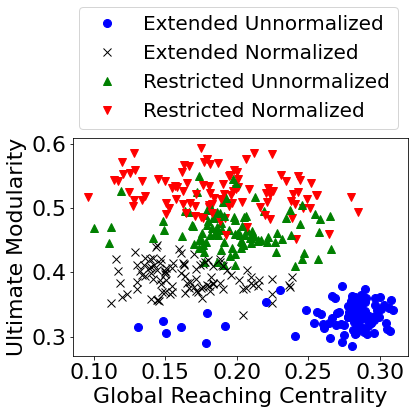

In [13]:
for i in range(0,Nsub-1):
    plt.plot(grc[i],mod[i],marker="o", markersize=8, color="blue")
    plt.plot(grcv[i],modv[i],marker="x", markersize=8, color="black")
    plt.plot(grcr[i],modr[i],marker="^", markersize=8, color="green")
    plt.plot(grcvr[i],modvr[i],marker="v", markersize=8, color="red")
plt.plot(grc[Nsub-1],mod[Nsub-1],marker="o", markersize=8, color="blue",label="Extended Unnormalized",linestyle = 'None')
plt.plot(grcv[Nsub-1],modv[Nsub-1],marker="x", markersize=8, color="black",label="Extended Normalized",linestyle = 'None')
plt.plot(grcr[Nsub-1],modr[Nsub-1],marker="^", markersize=8, color="green",label="Restricted Unnormalized",linestyle = 'None')
plt.plot(grcvr[Nsub-1],modvr[Nsub-1],marker="v", markersize=8, color="red",label="Restricted Normalized",linestyle = 'None')
plt.legend(bbox_to_anchor=(1, 1.65),fontsize=20)
plt.ylabel("Ultimate Modularity")
plt.xlabel("Global Reaching Centrality")
plt.rcParams['font.size'] = '22'
plt.show()

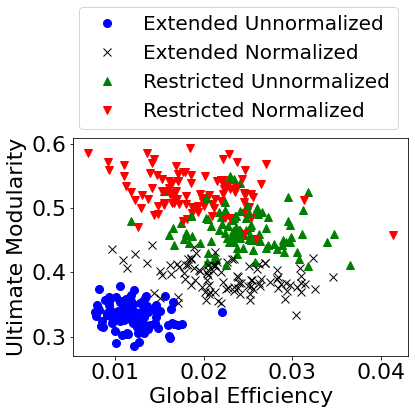

In [14]:
for i in range(0,Nsub-1):
    plt.plot(gleff[i],mod[i],marker="o", markersize=8, color="blue")
    plt.plot(gleffv[i],modv[i],marker="x", markersize=8, color="black")
    plt.plot(gleffr[i],modr[i],marker="^", markersize=8, color="green")
    plt.plot(gleffvr[i],modvr[i],marker="v", markersize=8, color="red")
plt.plot(gleff[Nsub-1],mod[Nsub-1],marker="o", markersize=8, color="blue",label="Extended Unnormalized",linestyle = 'None')
plt.plot(gleffv[Nsub-1],modv[Nsub-1],marker="x", markersize=8, color="black",label="Extended Normalized",linestyle = 'None')
plt.plot(gleffr[Nsub-1],modr[Nsub-1],marker="^", markersize=8, color="green",label="Restricted Unnormalized",linestyle = 'None')
plt.plot(gleffvr[Nsub-1],modvr[Nsub-1],marker="v", markersize=8, color="red",label="Restricted Normalized",linestyle = 'None')
plt.legend(bbox_to_anchor=(1, 1.65),fontsize=20)
plt.ylabel("Ultimate Modularity")
plt.xlabel("Global Efficiency")
plt.rcParams['font.size'] = '22'
plt.show()

In [15]:
nfirst=0 #first subject
nlast=Nsub #last subject
degmean=np.zeros(Nregions)
deg2mean=np.zeros(Nregions)
eigmean=np.zeros(Nregions)
eig2mean=np.zeros(Nregions)
betmean=np.zeros(Nregions)
bet2mean=np.zeros(Nregions)
degvmean=np.zeros(Nregions)
degv2mean=np.zeros(Nregions)
eigvmean=np.zeros(Nregions)
eigv2mean=np.zeros(Nregions)
betvmean=np.zeros(Nregions)
betv2mean=np.zeros(Nregions)



for i in range(0,Nregions):
    for j in range(nfirst,nlast):
        degmean[i]=degmean[i]+deg[j][i]
        deg2mean[i]=deg2mean[i]+deg[j][i]**2
    degmean[i]=degmean[i]/(nlast-nfirst)
    deg2mean[i]=deg2mean[i]/(nlast-nfirst)
degσ=np.sqrt(deg2mean-degmean**2)

for i in range(0,Nregions):
    for j in range(nfirst,nlast):
        eigmean[i]=eigmean[i]+abs(eig[j][i])
        eig2mean[i]=eig2mean[i]+eig[j][i]**2
    eigmean[i]=eigmean[i]/(nlast-nfirst)
    eig2mean[i]=eig2mean[i]/(nlast-nfirst)
eigσ=np.sqrt(eig2mean-eigmean**2)

for i in range(0,Nregions):
    for j in range(nfirst,nlast):
        betmean[i]=betmean[i]+bet[j][i]
        bet2mean[i]=bet2mean[i]+bet[j][i]**2
    betmean[i]=betmean[i]/(nlast-nfirst)
    bet2mean[i]=bet2mean[i]/(nlast-nfirst)
betσ=np.sqrt(bet2mean-betmean**2)

for i in range(0,Nregions):
    for j in range(nfirst,nlast):
        degvmean[i]=degvmean[i]+degv[j][i]
        degv2mean[i]=degv2mean[i]+degv[j][i]**2
    degvmean[i]=degvmean[i]/(nlast-nfirst)
    degv2mean[i]=degv2mean[i]/(nlast-nfirst)
degvσ=np.sqrt(degv2mean-degvmean**2)

for i in range(0,Nregions):
    for j in range(nfirst,nlast):
        eigvmean[i]=eigvmean[i]+abs(eigv[j][i])
        eigv2mean[i]=eigv2mean[i]+eigv[j][i]**2
    eigvmean[i]=eigvmean[i]/(nlast-nfirst)
    eigv2mean[i]=eigv2mean[i]/(nlast-nfirst)
eigvσ=np.sqrt(eigv2mean-eigvmean**2)

for i in range(0,Nregions):
    for j in range(nfirst,nlast):
        betvmean[i]=betvmean[i]+betv[j][i]
        betv2mean[i]=betv2mean[i]+betv[j][i]**2
    betvmean[i]=betvmean[i]/(nlast-nfirst)
    betv2mean[i]=betv2mean[i]/(nlast-nfirst)
betvσ=np.sqrt(betv2mean-betvmean**2)


In [16]:
nfirst=0 #first subject
nlast=Nsub #last subject
degrmean=np.zeros(Nregionsr)
degr2mean=np.zeros(Nregionsr)
eigrmean=np.zeros(Nregionsr)
eigr2mean=np.zeros(Nregionsr)
betrmean=np.zeros(Nregionsr)
betr2mean=np.zeros(Nregionsr)
degvrmean=np.zeros(Nregionsr)
degvr2mean=np.zeros(Nregionsr)
eigvrmean=np.zeros(Nregionsr)
eigvr2mean=np.zeros(Nregionsr)
betvrmean=np.zeros(Nregionsr)
betvr2mean=np.zeros(Nregionsr)

for i in range(0,Nregionsr):
    for j in range(nfirst,nlast):
        degrmean[i]=degrmean[i]+degr[j][i]
        degr2mean[i]=degr2mean[i]+degr[j][i]**2
    degrmean[i]=degrmean[i]/(nlast-nfirst)
    degr2mean[i]=degr2mean[i]/(nlast-nfirst)
degrσ=np.sqrt(degr2mean-degrmean**2)

for i in range(0,Nregionsr):
    for j in range(nfirst,nlast):
        eigrmean[i]=eigrmean[i]+abs(eigr[j][i])
        eigr2mean[i]=eigr2mean[i]+eigr[j][i]**2
    eigrmean[i]=eigrmean[i]/(nlast-nfirst)
    eigr2mean[i]=eigr2mean[i]/(nlast-nfirst)
eigrσ=np.sqrt(eigr2mean-eigrmean**2)

for i in range(0,Nregionsr):
    for j in range(nfirst,nlast):
        betrmean[i]=betrmean[i]+betr[j][i]
        betr2mean[i]=betr2mean[i]+betr[j][i]**2
    betrmean[i]=betrmean[i]/(nlast-nfirst)
    betr2mean[i]=betr2mean[i]/(nlast-nfirst)
betrσ=np.sqrt(betr2mean-betrmean**2)

for i in range(0,Nregionsr):
    for j in range(nfirst,nlast):
        degvrmean[i]=degvrmean[i]+degvr[j][i]
        degvr2mean[i]=degvr2mean[i]+degvr[j][i]**2
    degvrmean[i]=degvrmean[i]/(nlast-nfirst)
    degvr2mean[i]=degvr2mean[i]/(nlast-nfirst)
degvrσ=np.sqrt(degvr2mean-degvrmean**2)

for i in range(0,Nregionsr):
    for j in range(nfirst,nlast):
        eigvrmean[i]=eigvrmean[i]+abs(eigvr[j][i])
        eigvr2mean[i]=eigvr2mean[i]+eigvr[j][i]**2
    eigvrmean[i]=eigvrmean[i]/(nlast-nfirst)
    eigvr2mean[i]=eigvr2mean[i]/(nlast-nfirst)
eigvrσ=np.sqrt(eigvr2mean-eigvrmean**2)

for i in range(0,Nregionsr):
    for j in range(nfirst,nlast):
        betvrmean[i]=betvrmean[i]+betvr[j][i]
        betvr2mean[i]=betvr2mean[i]+betvr[j][i]**2
    betvrmean[i]=betvrmean[i]/(nlast-nfirst)
    betvr2mean[i]=betvr2mean[i]/(nlast-nfirst)
betvrσ=np.sqrt(betvr2mean-betvrmean**2)

(array([60., 16., 14.,  5.,  2.,  1.,  0.,  1.,  0.,  1.]),
 array([0.        , 0.0180429 , 0.03608581, 0.05412871, 0.07217161,
        0.09021452, 0.10825742, 0.12630032, 0.14434323, 0.16238613,
        0.18042903]),
 <BarContainer object of 10 artists>)

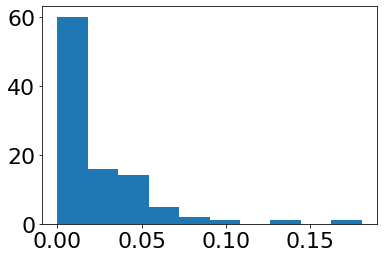

In [17]:
betvrcaud=np.zeros(Nsub) 
for i in range(0,Nsub):
    betvrcaud[i]=betvr[i][64]
plt.hist(betvrcaud)

In [18]:
degmeanlist=heapq.nlargest(ntop, zip(degmean, ind104))
degvmeanlist=heapq.nlargest(ntop, zip(degvmean, ind104))
eigmeanlist=heapq.nlargest(ntop, zip(eigmean, ind104))
eigvmeanlist=heapq.nlargest(ntop, zip(eigvmean, ind104))
betmeanlist=heapq.nlargest(ntop, zip(betmean, ind104))
betvmeanlist=heapq.nlargest(ntop, zip(betvmean, ind104))
betmeanlist

[(0.4374490767180661, 9.0),
 (0.24978869217589955, 62.0),
 (0.23027984009137628, 96.0),
 (0.1653207690843327, 58.0),
 (0.1583742623262898, 3.0),
 (0.144355606320198, 22.0),
 (0.14103369503141058, 20.0),
 (0.12018084903864461, 92.0),
 (0.10830763373310491, 5.0),
 (0.09895107557586141, 97.0)]

In [19]:
degrmeanlist=heapq.nlargest(ntop, zip(degrmean, ind84))
degvrmeanlist=heapq.nlargest(ntop, zip(degvrmean, ind84))
eigrmeanlist=heapq.nlargest(ntop, zip(eigrmean, ind84))
eigvrmeanlist=heapq.nlargest(ntop, zip(eigvrmean, ind84))
betrmeanlist=heapq.nlargest(ntop, zip(betrmean, ind84))
betvrmeanlist=heapq.nlargest(ntop, zip(betvrmean, ind84))
betrmeanlist

[(0.5255803702615338, 1.0),
 (0.506403173670291, 9.0),
 (0.2050455480458419, 42.0),
 (0.18377901851307676, 76.0),
 (0.17648839259476937, 11.0),
 (0.13966206288568914, 77.0),
 (0.13587422862180434, 38.0),
 (0.13163091389950052, 3.0),
 (0.1234352042315604, 10.0),
 (0.11946223920070528, 43.0)]

In [20]:
degvmean[2]/degvmean[5] #the cerebellum degree centrality in the volume-normalized extended connectome 

0.1340742354375583

In [21]:
eigvmean[2]/eigvmean[5] #the cerebellum eigenvector centrality in the volume-normalized extended connectome 

0.17198896557822363

In [22]:
betvmean[2]/betvmean[5] #the cerebellum betweenness centrality in the volume-normalized extended connectome 

0.00030473868657626083

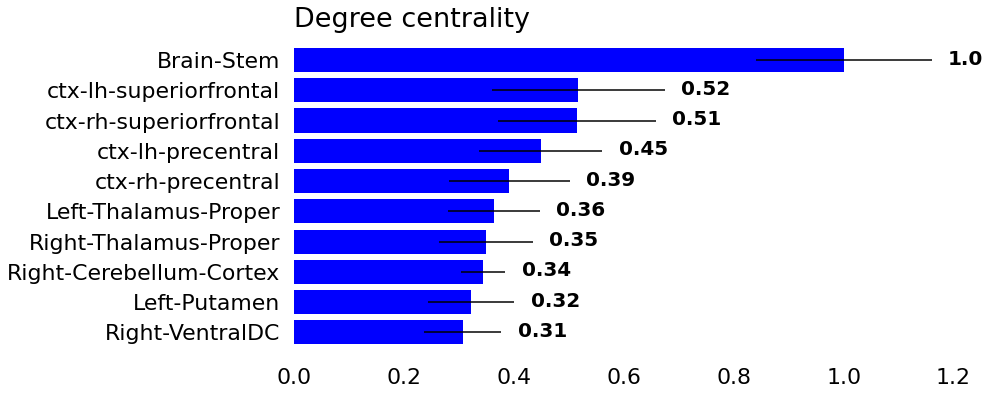

In [23]:
xmeandeg=[]
ymeandegerr=[]
for i in range(0,ntop):
    xmeandeg.append(J104labels[round(degmeanlist[i][1])])
    ymeandegerr.append(degσ[round(degmeanlist[i][1])])
ymeandeg=np.zeros(ntop)
for i in range(0,ntop):
    ymeandeg[i]=degmeanlist[i][0]
ymeandegmax=ymeandeg[0]
ymeandeg=ymeandeg/ymeandegmax
ymeandegerr=ymeandegerr/ymeandegmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeandeg[::-1], ymeandeg[::-1], xerr=ymeandegerr[::-1], color='blue')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeandegerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Degree centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

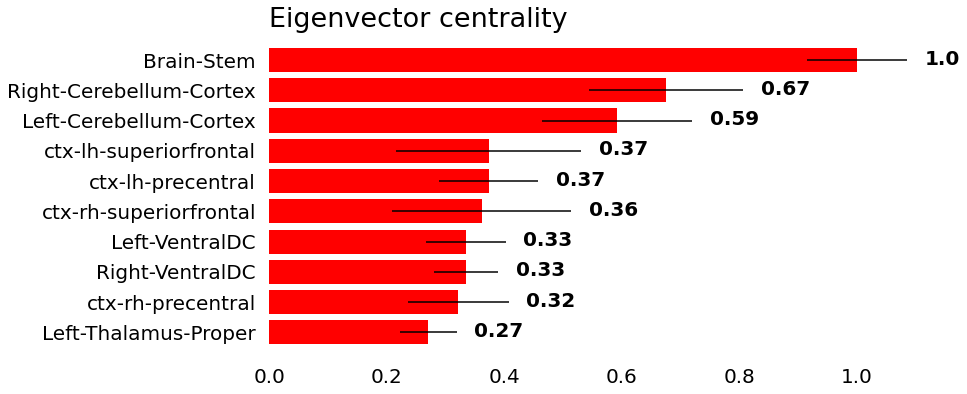

In [24]:
xmeaneig=[]
ymeaneigerr=[]
for i in range(0,ntop):
    xmeaneig.append(J104labels[round(eigmeanlist[i][1])])
    ymeaneigerr.append(eigσ[round(eigmeanlist[i][1])])
ymeaneig=np.zeros(ntop)
for i in range(0,ntop):
    ymeaneig[i]=eigmeanlist[i][0]
ymeaneigmax=ymeaneig[0]
ymeaneig=ymeaneig/ymeaneigmax
ymeaneigerr=ymeaneigerr/ymeaneigmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeaneig[::-1], ymeaneig[::-1], xerr=ymeaneigerr[::-1], color='red')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeaneigerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Eigenvector centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

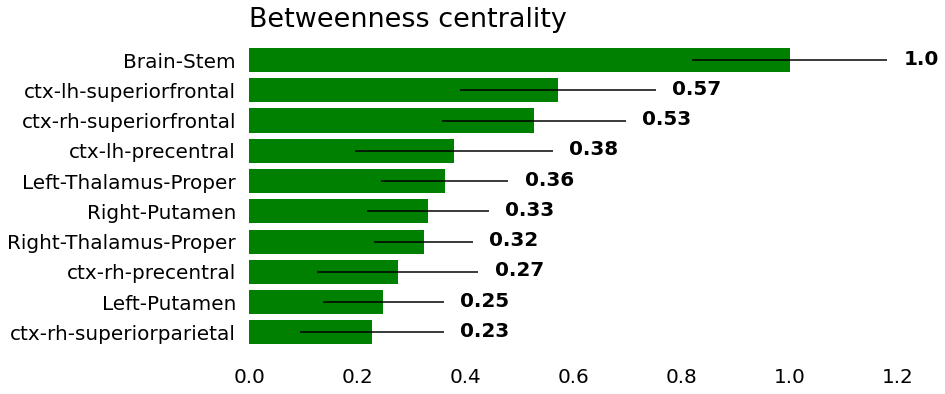

In [25]:
xmeanbet=[]
ymeanbeterr=[]
for i in range(0,ntop):
    xmeanbet.append(J104labels[round(betmeanlist[i][1])])
    ymeanbeterr.append(betσ[round(betmeanlist[i][1])])
ymeanbet=np.zeros(ntop)
for i in range(0,ntop):
    ymeanbet[i]=betmeanlist[i][0]
ymeanbetmax=ymeanbet[0]
ymeanbet=ymeanbet/ymeanbetmax
ymeanbeterr=ymeanbeterr/ymeanbetmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeanbet[::-1], ymeanbet[::-1], xerr=ymeanbeterr[::-1], color='green')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeanbeterr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Betweenness centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

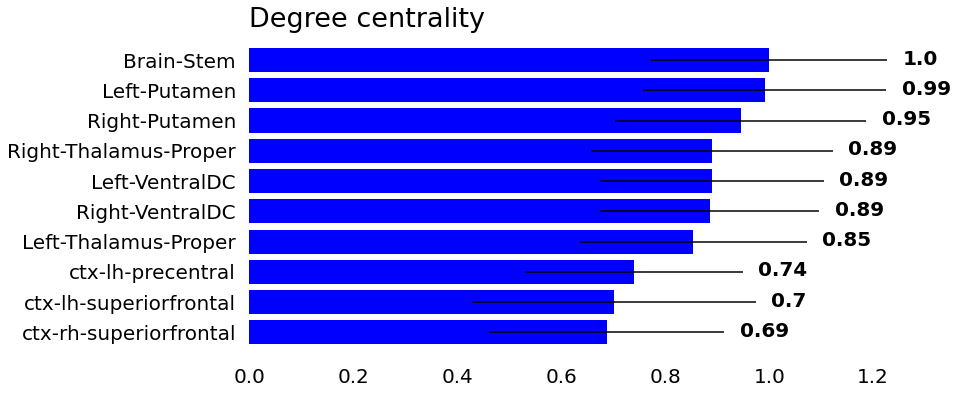

In [26]:
xmeandegv=[]
ymeandegverr=[]
for i in range(0,ntop):
    xmeandegv.append(J104labels[round(degvmeanlist[i][1])])
    ymeandegverr.append(degvσ[round(degvmeanlist[i][1])])
ymeandegv=np.zeros(ntop)
for i in range(0,ntop):
    ymeandegv[i]=degvmeanlist[i][0]
ymeandegvmax=ymeandegv[0]
ymeandegv=ymeandegv/ymeandegvmax
ymeandegverr=ymeandegverr/ymeandegvmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeandegv[::-1], ymeandegv[::-1], xerr=ymeandegverr[::-1], color='blue')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeandegverr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Degree centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

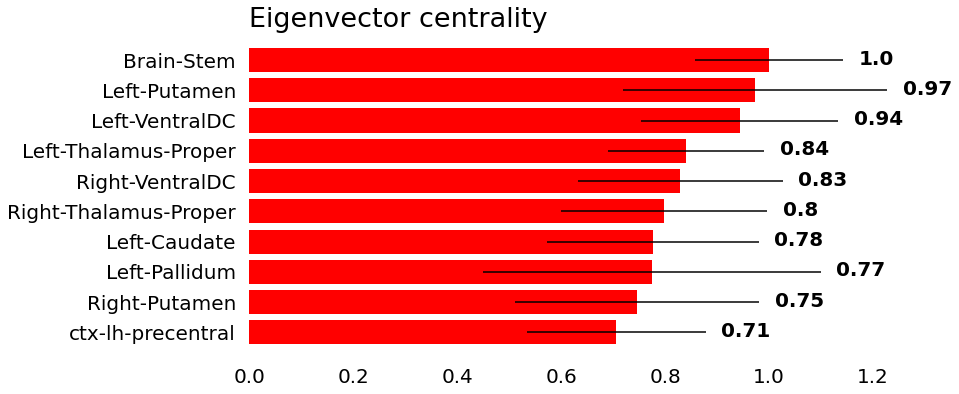

In [27]:
xmeaneigv=[]
ymeaneigverr=[]
for i in range(0,ntop):
    xmeaneigv.append(J104labels[round(eigvmeanlist[i][1])])
    ymeaneigverr.append(eigvσ[round(eigvmeanlist[i][1])])
ymeaneigv=np.zeros(ntop)
for i in range(0,ntop):
    ymeaneigv[i]=eigvmeanlist[i][0]
ymeaneigvmax=ymeaneigv[0]
ymeaneigv=ymeaneigv/ymeaneigvmax
ymeaneigverr=ymeaneigverr/ymeaneigvmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeaneigv[::-1], ymeaneigv[::-1], xerr=ymeaneigverr[::-1], color='red')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeaneigverr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Eigenvector centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

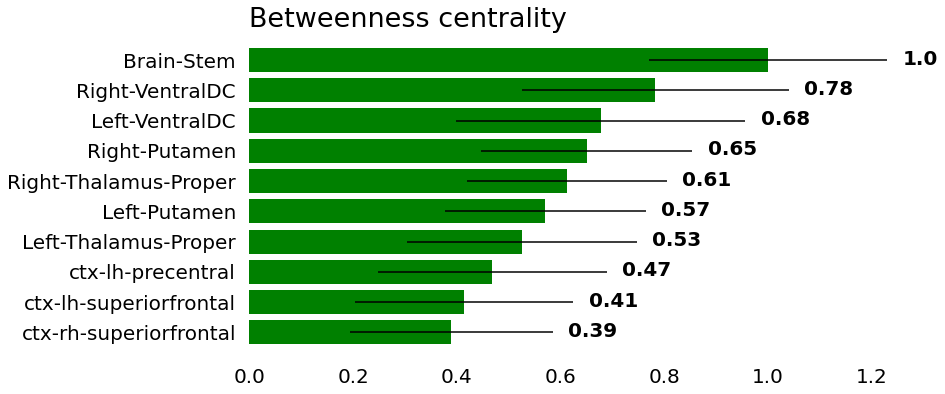

In [28]:
xmeanbetv=[]
ymeanbetverr=[]
for i in range(0,ntop):
    xmeanbetv.append(J104labels[round(betvmeanlist[i][1])])
    ymeanbetverr.append(betvσ[round(betvmeanlist[i][1])])
ymeanbetv=np.zeros(ntop)
for i in range(0,ntop):
    ymeanbetv[i]=betvmeanlist[i][0]
ymeanbetvmax=ymeanbetv[0]
ymeanbetv=ymeanbetv/ymeanbetvmax
ymeanbetverr=ymeanbetverr/ymeanbetvmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeanbetv[::-1], ymeanbetv[::-1], xerr=ymeanbetverr[::-1], color='green')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeanbetverr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Betweenness centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

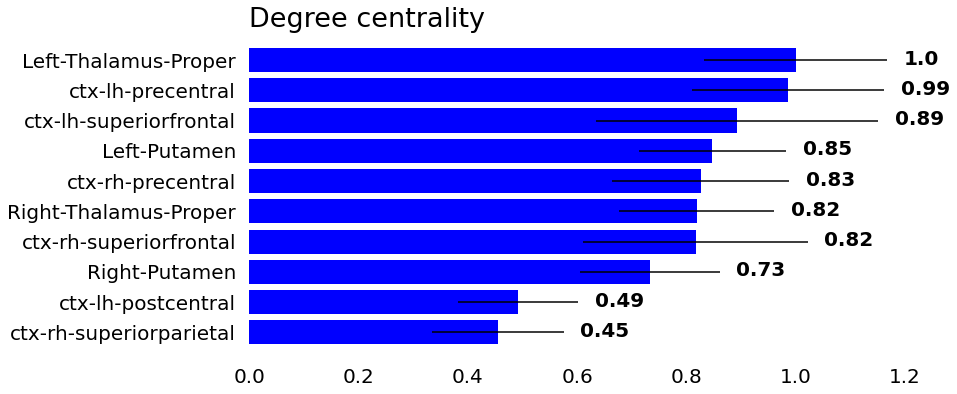

In [29]:
xmeandegr=[] 
ymeandegrerr=[]
for i in range(0,ntop):
    xmeandegr.append(J84labels[round(degrmeanlist[i][1])])
    ymeandegrerr.append(degrσ[round(degrmeanlist[i][1])])
ymeandegr=np.zeros(ntop)
for i in range(0,ntop):
    ymeandegr[i]=degrmeanlist[i][0]
ymeandegrmax=ymeandegr[0]
ymeandegr=ymeandegr/ymeandegrmax
ymeandegrerr=ymeandegrerr/ymeandegrmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeandegr[::-1], ymeandegr[::-1], xerr=ymeandegrerr[::-1], color='blue')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeandegrerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Degree centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

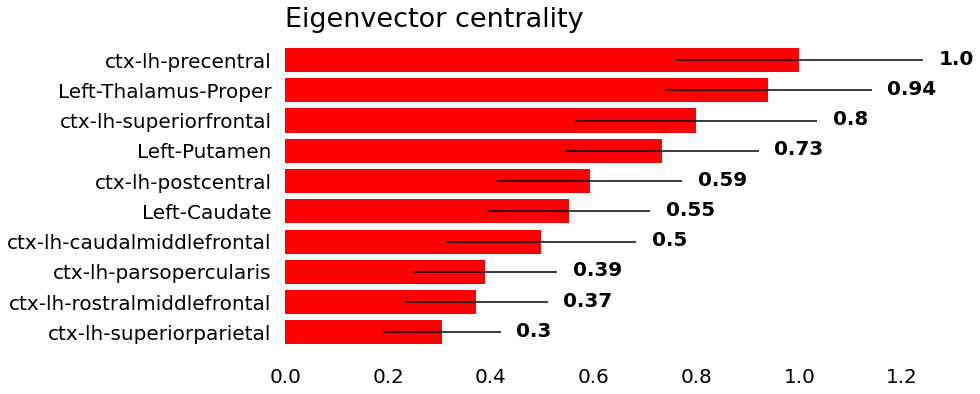

In [30]:
xmeaneigr=[]
ymeaneigrerr=[]
for i in range(0,ntop):
    xmeaneigr.append(J84labels[round(eigrmeanlist[i][1])])
    ymeaneigrerr.append(eigrσ[round(eigrmeanlist[i][1])])
ymeaneigr=np.zeros(ntop)
for i in range(0,ntop):
    ymeaneigr[i]=eigrmeanlist[i][0]
ymeaneigrmax=ymeaneigr[0]
ymeaneigr=ymeaneigr/ymeaneigrmax
ymeaneigrerr=ymeaneigrerr/ymeaneigrmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeaneigr[::-1], ymeaneigr[::-1], xerr=ymeaneigrerr[::-1], color='red')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeaneigrerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Eigenvector centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

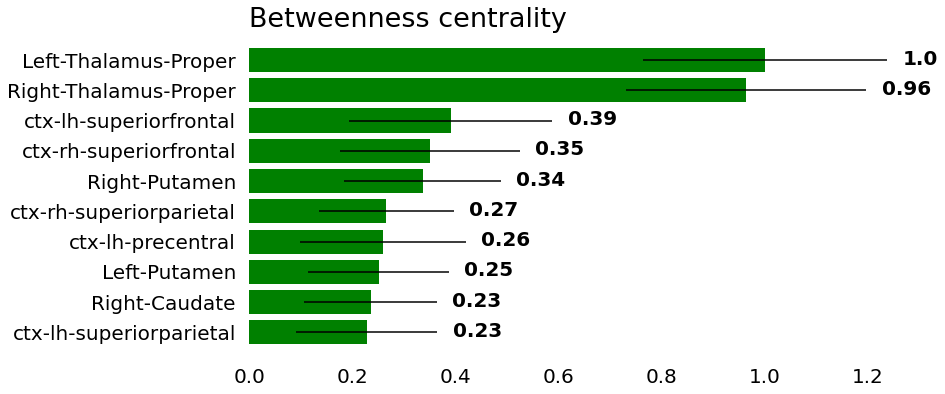

In [31]:
xmeanbetr=[] 
ymeanbetrerr=[]
for i in range(0,ntop):
    xmeanbetr.append(J84labels[round(betrmeanlist[i][1])])
    ymeanbetrerr.append(betrσ[round(betrmeanlist[i][1])])
ymeanbetr=np.zeros(ntop)
for i in range(0,ntop):
    ymeanbetr[i]=betrmeanlist[i][0]
ymeanbetrmax=ymeanbetr[0]
ymeanbetr=ymeanbetr/ymeanbetrmax
ymeanbetrerr=ymeanbetrerr/ymeanbetrmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeanbetr[::-1], ymeanbetr[::-1], xerr=ymeanbetrerr[::-1], color='green')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeanbetrerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Betweenness centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

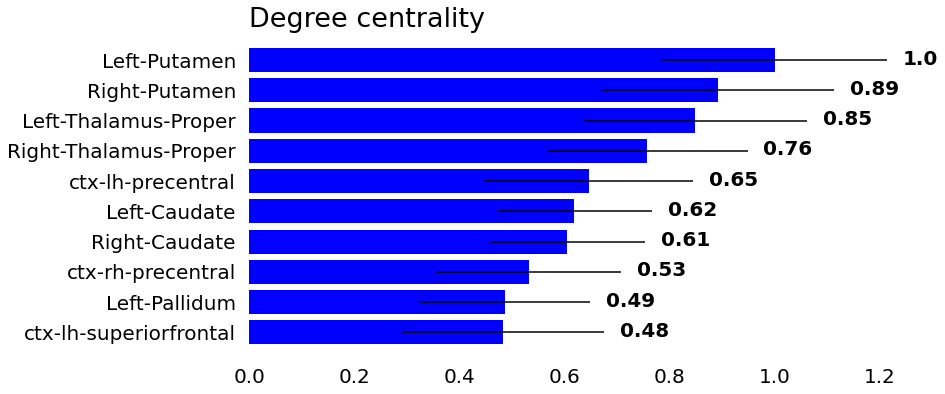

In [32]:
xmeandegvr=[] 
ymeandegvrerr=[]
for i in range(0,ntop):
    xmeandegvr.append(J84labels[round(degvrmeanlist[i][1])])
    ymeandegvrerr.append(degvrσ[round(degvrmeanlist[i][1])])
ymeandegvr=np.zeros(ntop)
for i in range(0,ntop):
    ymeandegvr[i]=degvrmeanlist[i][0]
ymeandegvrmax=ymeandegvr[0]
ymeandegvr=ymeandegvr/ymeandegvrmax
ymeandegvrerr=ymeandegvrerr/ymeandegvrmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeandegvr[::-1], ymeandegvr[::-1], xerr=ymeandegvrerr[::-1], color='blue')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeandegvrerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Degree centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

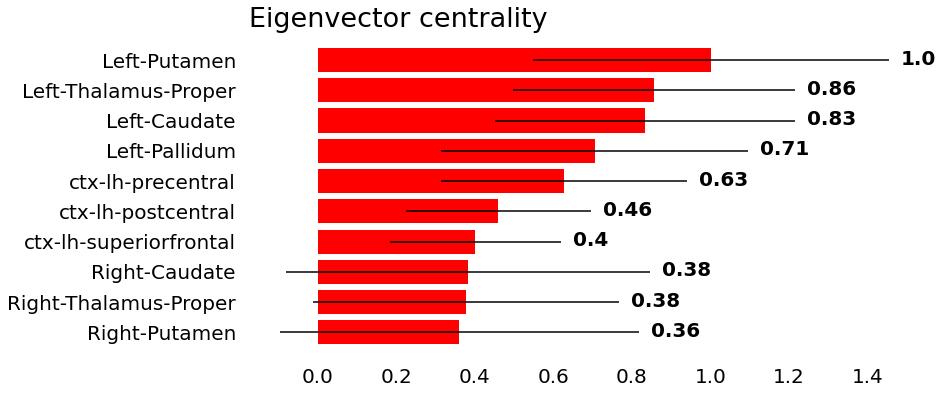

In [33]:
xmeaneigvr=[] 
ymeaneigvrerr=[]
for i in range(0,ntop):
    xmeaneigvr.append(J84labels[round(eigvrmeanlist[i][1])])
    ymeaneigvrerr.append(eigvrσ[round(eigvrmeanlist[i][1])])
ymeaneigvr=np.zeros(ntop)
for i in range(0,ntop):
    ymeaneigvr[i]=eigvrmeanlist[i][0]
ymeaneigvrmax=ymeaneigvr[0]
ymeaneigvr=ymeaneigvr/ymeaneigvrmax
ymeaneigvrerr=ymeaneigvrerr/ymeaneigvrmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeaneigvr[::-1], ymeaneigvr[::-1], xerr=ymeaneigvrerr[::-1], color='red')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeaneigvrerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1


ax.set_title('Eigenvector centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 

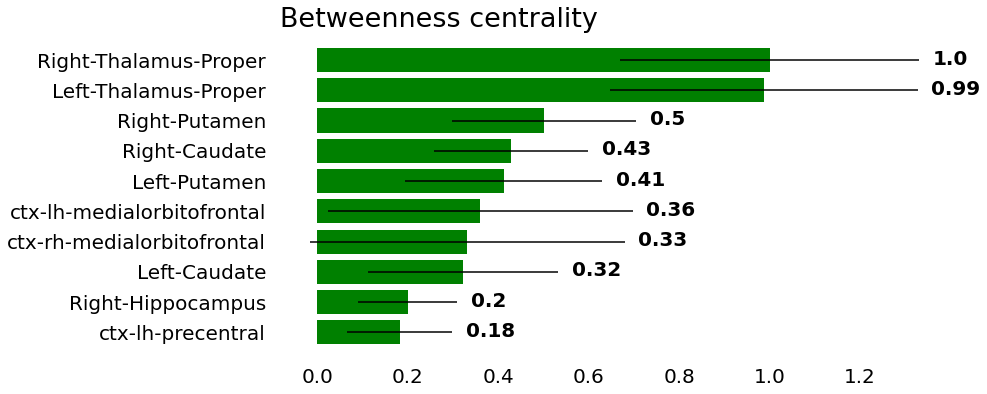

In [34]:
xmeanbetvr=[] 
ymeanbetvrerr=[]
for i in range(0,ntop):
    xmeanbetvr.append(J84labels[round(betvrmeanlist[i][1])])
    ymeanbetvrerr.append(betvrσ[round(betvrmeanlist[i][1])])
ymeanbetvr=np.zeros(ntop)
for i in range(0,ntop):
    ymeanbetvr[i]=betvrmeanlist[i][0]
ymeanbetvrmax=ymeanbetvr[0]
ymeanbetvr=ymeanbetvr/ymeanbetvrmax
ymeanbetvrerr=ymeanbetvrerr/ymeanbetvrmax
fig, ax = plt.subplots(figsize =(12, 6))
ax.barh(xmeanbetvr[::-1], ymeanbetvr[::-1], xerr=ymeanbetvrerr[::-1], color='green')

for s in ['top', 'bottom', 'left', 'right']: #removing splines
    ax.spines[s].set_visible(False)
    
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

ax.xaxis.set_tick_params(pad = 5) # Add padding between axes and labels
ax.yaxis.set_tick_params(pad = 10)

counter=ntop-1
for i in ax.patches: # Add annotation to bars
    plt.text(i.get_width()+0.03+ymeanbetvrerr[counter], i.get_y()+0.25,
             str(round((i.get_width()), 2)),
             fontsize = 20, fontweight ='bold',
             color ='black')
    counter=counter-1

ax.set_title('Betweenness centrality',loc ='left', fontsize=27)
plt.rc('ytick', labelsize=20) 
plt.rc('xtick', labelsize=20) 